In [1]:
import datetime
tick = datetime.datetime.now()

# Load libraries and helper functions

In [19]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda, GRU, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from utils import *
tf.keras.backend.set_floatx('float64')
%load_ext tensorboard

2.5.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
if IS_COLAB:
    !pip install keras-tuner

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU was detected. CNNs can be very slow without a GPU.


In [21]:
import kerastuner as kt

# Load single series

The data folder contains sales data (value and volume) for different regions of over the counter treatments for common cold and flu.

In [22]:
import os
datadir = './data/'
files = os.listdir(datadir)
files = [os.path.join(datadir, file) for file in files]

Let's load one series

In [23]:
file = [x for x in files if '00_volume' in x][0]
series = read_single_file(file)
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       292 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


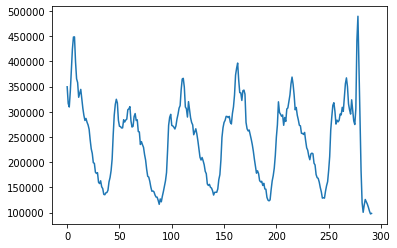

In [24]:
plt.plot(series)

Let's cut off the corona anomalies at the end.

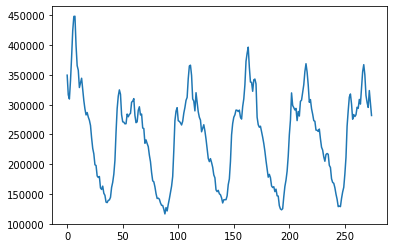

In [25]:
series = series[:275]
plt.plot(series)

## train-test split, normalize

We will have to make a train-test split.

Remember, with timeseries, you should always do it like this: the past is the train set, the future is the test set.

Using a random approach will lead to data-leaking and thus to overperformance! Make sure you understand why this is the case. It might seem like a detail, but it is not!

max: 0    448540.60504
dtype: float64


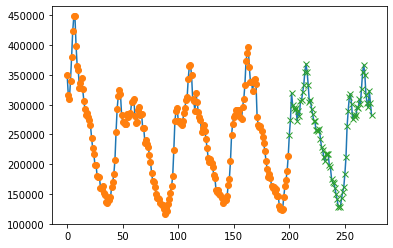

In [26]:
split_time = 200
x_train = series[:split_time]
x_valid = series[split_time:]
plt.plot(series)
plt.plot(x_train, 'o')
plt.plot(x_valid, 'x')

norm = x_train.max()
print('max:', norm)
x_train = x_train / norm
x_valid = x_valid / norm

In [27]:
# shape: (timesteps , features)
x_train.shape, x_valid.shape

((200, 1), (75, 1))

In [28]:
# make windowed dataset
window_size = 32
batch_size = 32
shuffle_buffer_size = 32
horizon = 8

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size, horizon)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size, horizon)

In [29]:
for x, y in train_set:
    print(x.shape)
    print(y.shape)
    seq_size = x.shape[1]
    break

for x, y in valid_set:
    print(x.shape)
    print(y.shape)
    break

(32, 32, 1)
(32, 8, 1)
(32, 32, 1)
(32, 8, 1)


In [30]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Look for a model

Let's explore a few models. A `mape` accuracy of around 85% is reasonable for this dataset.

In [31]:
for x, y in train_set:
    print(x.shape)
    print(y.shape)
    break

(32, 32, 1)
(32, 8, 1)


In [32]:
result = {}

Start with a baseline with one Dense(horizon) layer. horizon refers to the amount of outputs you need for the horizon of the prediction. Pay attention to the correct input shape! What is the input shape of your data? What is the input shape your Dense layer expects?

In [33]:
%%time

logdir = os.path.join("logs", "base")
tb = TensorBoard(logdir, histogram_freq=1)
# Baseline model, just a linear model
model = Sequential([
    Flatten(input_shape=[seq_size,1]),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(learning_rate=1e-2), metrics=['mape'])
result['base'] = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)

CPU times: user 9.08 s, sys: 909 ms, total: 9.99 s
Wall time: 7.55 s


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
Total params: 264
Trainable params: 264
Non-trainable params: 0
_________________________________________________________________


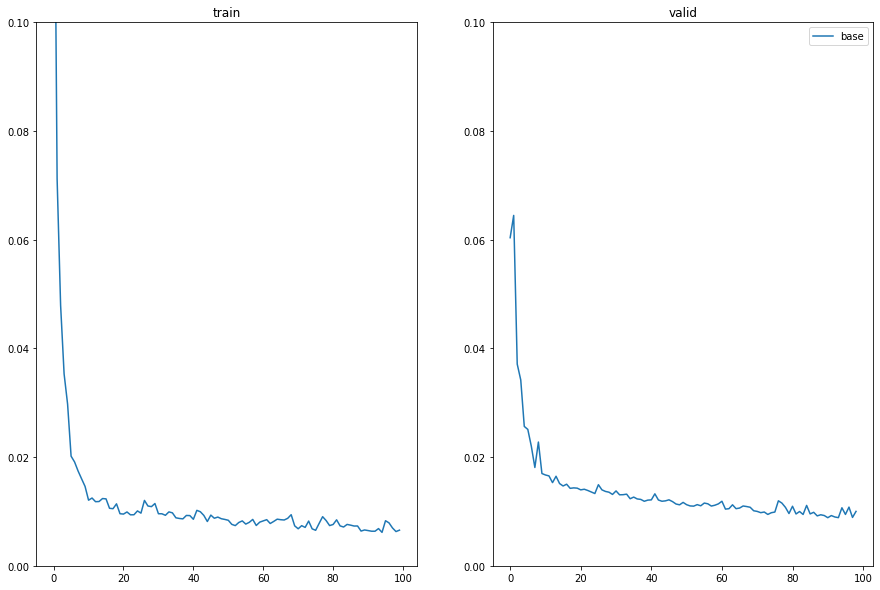

In [35]:
plot_results(result, ymax = 0.1)

In [36]:
model.evaluate(valid_set)

2/2 [==============================] - 0s 6ms/step - loss: 0.0092 - mape: 14.3701


[0.009177009471588664, 14.370095822690477]

Now, create a simple RNN with just one unit, and a Dense layer. Test this with a for loop for [1e-2, 1e-3, 1e-4] learning rates.

Try to predict what will happen. What do you expect for the different rates in terms of:

- accuracy
- speed
- stability

In [37]:
%%time

for lr in [1e-2, 1e-3, 1e-4]:
    name = 'simpleRNN_Adam_lr{0}'.format(lr)
    logdir = os.path.join("logs", name)
    tb = TensorBoard(logdir, histogram_freq=1)
    
    model = Sequential([
        SimpleRNN(1, input_shape=[None, 1]),
        Dense(horizon)
    ])

    model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=['mape'])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)
    print('lr:', lr, model.evaluate(valid_set))

2/2 [==============================] - 0s 7ms/step - loss: 0.0151 - mape: 21.6404
lr: 0.01 [0.015122318743831582, 21.640408943413618]
2/2 [==============================] - 0s 6ms/step - loss: 0.0215 - mape: 27.7927
lr: 0.001 [0.02146814898070362, 27.792662494674907]
2/2 [==============================] - 0s 8ms/step - loss: 0.0998 - mape: 44.9900
lr: 0.0001 [0.09983842240439521, 44.98999013615807]
CPU times: user 1min 1s, sys: 6.76 s, total: 1min 8s
Wall time: 47.4 s


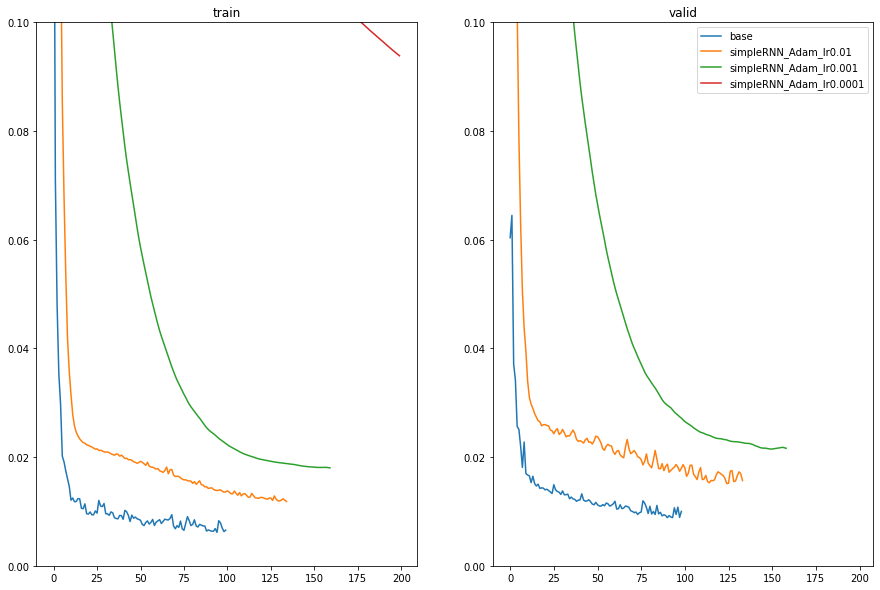

In [38]:
plot_results(result, ymax = 0.1)


A high learning rate (0.01) gives faster results. It's a bit more instable. This is to be expected: a high learning rate moves fast, but is unable to make gentle adjustments.

Interpret the mape. What seems to work better?

Expand the amount of units of your RNN to 16, and test for the same range or learning rates.
Also, test both ADAM and SGD with momentum.

Again, try to formulate a hypothesis first.

What do you expect in terms of accuracy? speed? stability?

And why do you expect that? (cf., try to give a reason instead of just guessing).

In [39]:
%%time

for lr in [1e-2, 1e-3, 1e-4]:
    name = 'Deep_RNN_Adam_lr{0}'.format(lr)
    logdir = os.path.join("logs", name)
    tb = TensorBoard(logdir, histogram_freq=1)
    
    model = Sequential([
        SimpleRNN(16, input_shape=[None, 1]),
        Dense(horizon)
    ])

    model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=['mape'])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, verbose=0,
    callbacks=[tb])
    print('lr:', lr, model.evaluate(valid_set))

2/2 [==============================] - 0s 8ms/step - loss: 0.0034 - mape: 10.2699
lr: 0.01 [0.0033936182347436747, 10.26985502270038]
2/2 [==============================] - 0s 7ms/step - loss: 0.0075 - mape: 14.8789
lr: 0.001 [0.007507999531096882, 14.87890734008047]
2/2 [==============================] - 0s 8ms/step - loss: 0.0200 - mape: 24.1243
lr: 0.0001 [0.01999008220930894, 24.12430181938313]
CPU times: user 1min 21s, sys: 11.3 s, total: 1min 32s
Wall time: 55.5 s


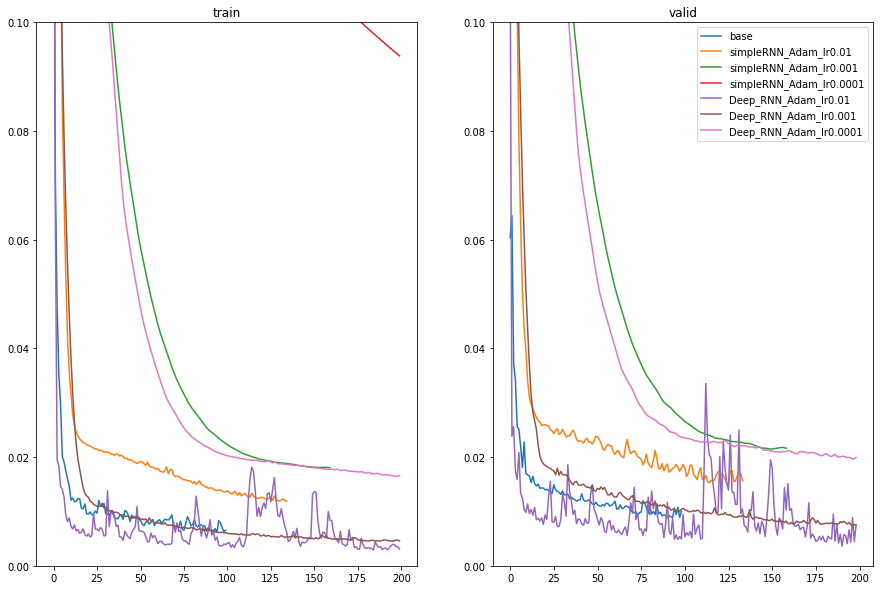

In [40]:
plot_results(result, ymax = 0.1)

The deep network adds more complexity, and thus performs better. One unit is way too simple for all the patterns in the data.

We can see the Adam 0.01 to go deep fast, but to suffer from the roughness. Might be an option here to lower the learningrate after approximate 20 epochs, as the 0.001 Adam is much more stable.

Again, this should be expected from theory.



In [41]:
%%time
for lr in [1e-2, 1e-3, 1e-4]:
    name = 'Deep_RNN_SGD_lr{0}'.format(lr)
    logdir = os.path.join("logs", name)
    tb = TensorBoard(logdir, histogram_freq=1)
    
    model = Sequential([
        SimpleRNN(16, input_shape=[None, 1]),
        Dense(horizon)
    ])

    model.compile(loss="mse", optimizer=SGD(learning_rate=lr, momentum=0.9), metrics=['mape'])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)
    print('lr:', lr, model.evaluate(valid_set))

2/2 [==============================] - 0s 10ms/step - loss: 0.0059 - mape: 13.4566
lr: 0.01 [0.005934102667702569, 13.456622123795677]
2/2 [==============================] - 0s 7ms/step - loss: 0.0215 - mape: 27.2420
lr: 0.001 [0.021521462748448055, 27.242042350399345]
2/2 [==============================] - 0s 6ms/step - loss: 0.0353 - mape: 32.7998
lr: 0.0001 [0.03525705635547638, 32.79983835157354]
CPU times: user 1min 1s, sys: 8.22 s, total: 1min 9s
Wall time: 43 s


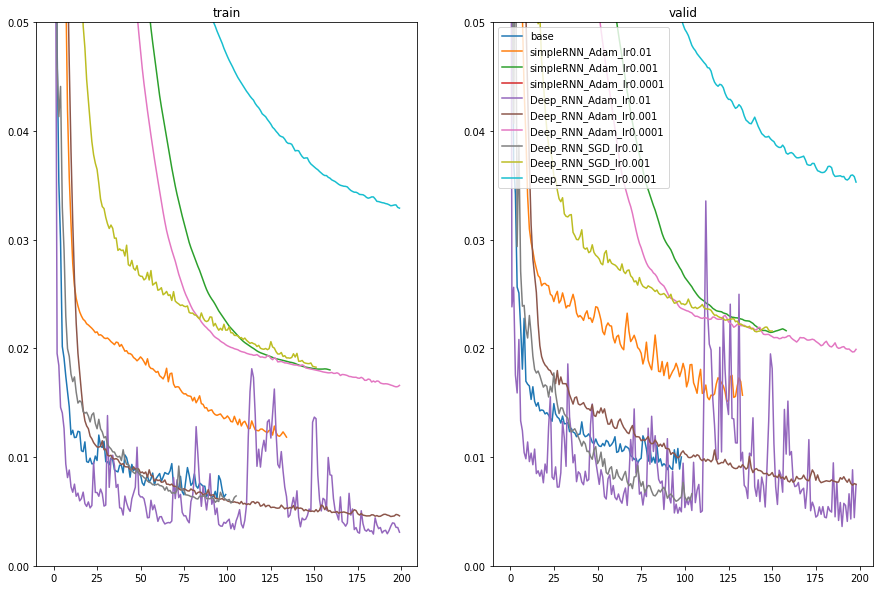

In [42]:
plot_results(result, ymax = 0.05)

In [43]:
%tensorboard --logdir logs

The SGD 0.01 is much more stable as the adam 0.01.
This is hard to predict in advance, but it something I have seen more often with timeseries. Somehow, trying to predict the direction in addition to the momentum adds instability at a learning rate of 0.01.

While the Adam 0.01 outperforms the SGD, it is way too unstable to simply use it at 0.01. So we should have to add some decay if we want to use Adam.

In [44]:
allkeys = list(result.keys())
allkeys

['base',
 'simpleRNN_Adam_lr0.01',
 'simpleRNN_Adam_lr0.001',
 'simpleRNN_Adam_lr0.0001',
 'Deep_RNN_Adam_lr0.01',
 'Deep_RNN_Adam_lr0.001',
 'Deep_RNN_Adam_lr0.0001',
 'Deep_RNN_SGD_lr0.01',
 'Deep_RNN_SGD_lr0.001',
 'Deep_RNN_SGD_lr0.0001']

In [45]:
for key in allkeys:
    if key not in ['base','Deep_RNN_SGD_lr0.01', 'Deep_RNN_Adam_lr0.01']:
        print(key)
        del result[key]

simpleRNN_Adam_lr0.001
simpleRNN_Adam_lr0.0001
Deep_RNN_Adam_lr0.01
Deep_RNN_Adam_lr0.001
Deep_RNN_Adam_lr0.0001
Deep_RNN_SGD_lr0.001
Deep_RNN_SGD_lr0.0001


Then, try a SimpleRNN with SGD and `learning_rate=1e-3` and `momentum=0.9` and test three layers of SimpleRNN. Make a forloop to test 32, 64 and 96 units.

Again, try to make predictions about:
- speed
- accuracy
- stability

In [46]:
%%time
for units in [32, 64, 96]:
    name = 'SimpleRNN{0}'.format(units)
    logdir = os.path.join("logs", name)
    tb = TensorBoard(logdir, histogram_freq=1)
    model = Sequential([
        SimpleRNN(units, return_sequences=True, input_shape=[None, 1]),
        SimpleRNN(units, return_sequences=True),
        SimpleRNN(units),
        Dense(horizon)
    ])

    model.compile(loss="mse", optimizer=SGD(learning_rate=1e-3, momentum=0.9), metrics=['mape'])
    result[name] = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)
    print(name, model.evaluate(valid_set))

2/2 [==============================] - 0s 10ms/step - loss: 0.0102 - mape: 17.0317
SimpleRNN32 [0.01022263921590315, 17.031660428223656]
2/2 [==============================] - 0s 10ms/step - loss: 0.0074 - mape: 13.1576
SimpleRNN64 [0.007376692464782132, 13.157598956804746]
2/2 [==============================] - 0s 9ms/step - loss: 0.0100 - mape: 15.5692
SimpleRNN96 [0.0100206951610744, 15.569157066305507]
CPU times: user 1min 57s, sys: 21.9 s, total: 2min 19s
Wall time: 57 s


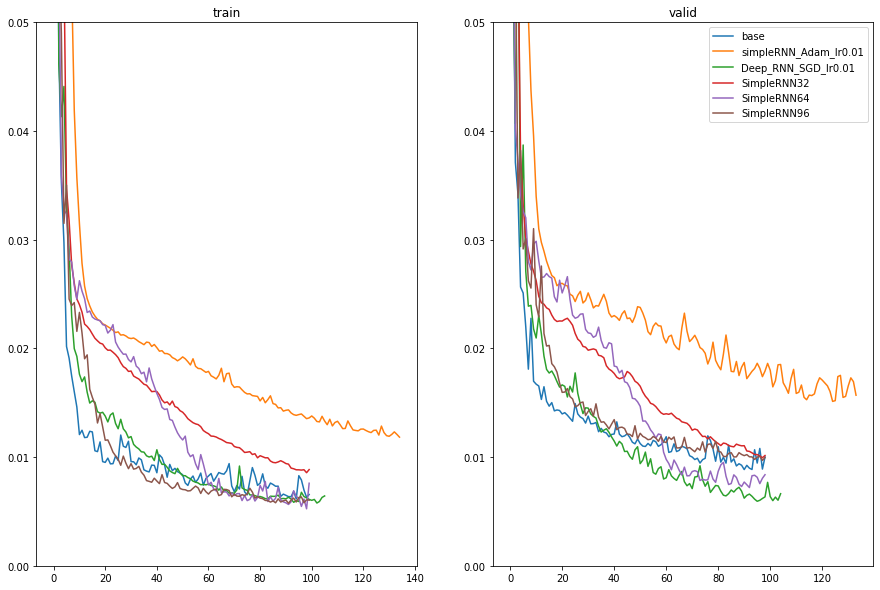

In [47]:
plot_results(result, ymax=0.05)


So, we are improving again a lot with more complexity. 64 units outperforms 32 and 96. However, this still could change with other learning rate schedules, but the model is able to faster find more complexity with more layers.


Now, switch to GRU to see if that improves the simple RNN. Use a forloop to test 32, 64 and 96 units.

In [52]:
%%time
from tensorflow.keras.layers import GRU

for units in [32, 64, 96]:
    name = 'GRU{0}'.format(units)
    logdir = os.path.join("logs", name)
    tb = TensorBoard(logdir, histogram_freq=1)
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=[None, 1]),
        GRU(units, return_sequences=True),
        GRU(units),
        Dense(horizon)
    ])

    model.compile(loss="mse", optimizer=Adam(), metrics=['mape'])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[tb], verbose=0)
    print(name, model.evaluate(valid_set))

2/2 [==============================] - 0s 12ms/step - loss: 0.0058 - mape: 9.6669
GRU32 [0.005815695816030105, 9.66694141747287]
2/2 [==============================] - 0s 14ms/step - loss: 0.0035 - mape: 8.3544
GRU64 [0.0035208219714048835, 8.35444722510696]
2/2 [==============================] - 0s 16ms/step - loss: 0.0039 - mape: 8.3772
GRU96 [0.0038934635101921028, 8.377244139444304]
CPU times: user 8min 8s, sys: 1min 39s, total: 9min 48s
Wall time: 3min 26s


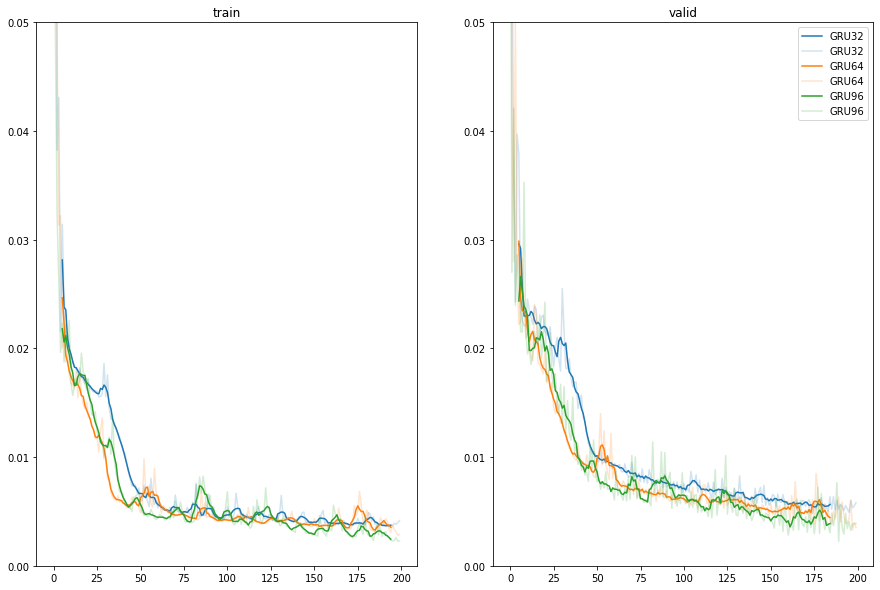

In [53]:
plot_results(result, ymax=0.05, moving=5, alpha=0.2, subset='GRU', patience=10)

With all these experiments, we gain an idea of what has impact, and what not.

In addition to that, we get a feeling for ranges.
- learning rate matters a lot
- picking an optimizer too
- the model obviously needs some complexity to find the patterns
- some memory seems to help it, too.

Now let's fixate the amount of units, based on your experiments so far, and add Conv1D filters to your best model.

Test for filters in your Conv1D layer of size 16, 32, 48.


In [54]:
%%time
for filters in [16, 32, 48]:
    name = 'GRU96_conv{0}'.format(filters)
    
    logdir = os.path.join("logs", name)
    tb = TensorBoard(logdir, histogram_freq=1)
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, strides=1, padding="valid",
                        input_shape=[None, 1]),
        GRU(96, return_sequences=True, input_shape=[None, 1]),
        GRU(96, return_sequences=True),
        GRU(96),
        Dense(horizon)
    ])

    model.compile(loss="mse", optimizer=Adam(), metrics=['mape'])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[tb], verbose=0)
    print(name, model.evaluate(valid_set))

2/2 [==============================] - 0s 12ms/step - loss: 0.0058 - mape: 9.7311
GRU64_conv16 [0.005800190511056119, 9.731078403781641]
2/2 [==============================] - 0s 13ms/step - loss: 0.0043 - mape: 8.3723
GRU64_conv32 [0.004272945147628586, 8.37231633356175]
2/2 [==============================] - 0s 12ms/step - loss: 0.0036 - mape: 8.1821
GRU64_conv48 [0.003603812126028869, 8.182137471141987]
CPU times: user 12min 15s, sys: 2min 39s, total: 14min 55s
Wall time: 4min 19s


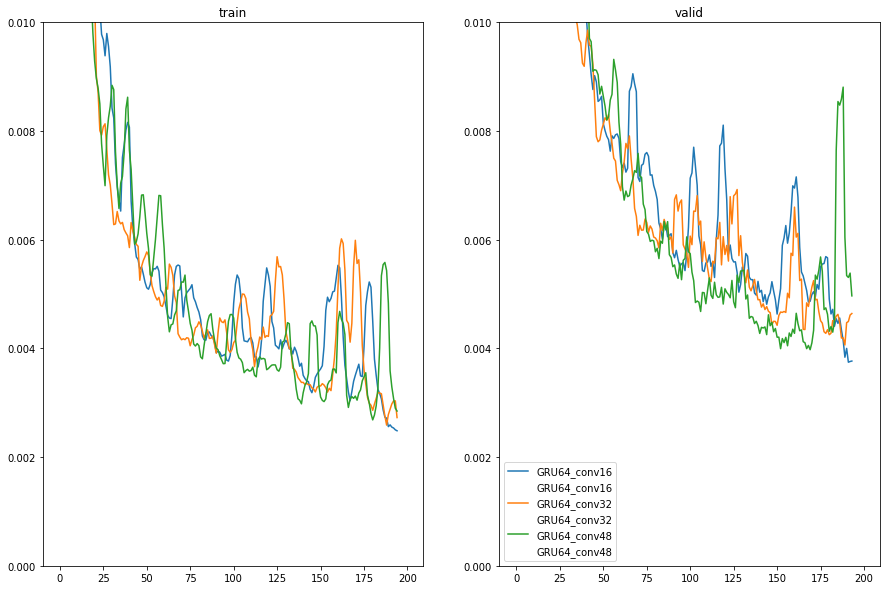

In [56]:
plot_results(result, ymax=0.01, moving=5, alpha=0, subset='conv')

You probably improved with Conv1D layer, again.

Problem is, it is hard to figure out what the best architecture is by freezing parameters and then adding new ones. It could be the case, that we have a complete new situation with the addition of the Conv1D layer, and thus that freezing the parameter for a layer without Conv1D is suboptimal. We are getting kind of lost in the multitude of options and possible interactions.

Hyperparametersettings and layers will interact, sometimes in unexpected ways. Maybe we would improve again if we **reduce** the amount of layers in combination with a conv1d layer.

The point here is, that while it is very usefull to play around with your model to get a good intuition of how your data reacts to changing learning rates, more units, other layers, etc, a lot of the times we can improve the architecture with a hypermodel.

Playing around often gives a good idea of what the fruitful areas are for your search; e.g should you think of units below 100? Or should you consider ranges up to 500 units? 

 # Hypermodel
The problem here is, that we can't just keep adding options and ranges. It will make our searchspace much to big, and the tuner is never able to try them all out. So, be carefull when adding a lot of features! 
 Another way to handle this is to start with a very broad model, and start to fix certain values if you are more confident that they shouldn't be changed.

Build a hypermodel. add parameters for:
- amounts of filters
- kernelsize
- GRU or LSTM
- amount of additional GRU/LSTM layers (be sure to also try 0 additional layers)

Be aware that our models are getting much slower to train. So increasing the `patience` in your `EarlyStopping` to a value of `20`, instead of `10`, when training your best model. With `10`, you might stop too early in the final model.

In [58]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, MaxPool1D

def build_model(hp):
    input = Input(shape = [None, 1])

    nfilters = hp.Int('filters', 40, 60, 4, default=48)
    x = Conv1D(filters=nfilters, kernel_size=3,
           strides=1, padding="causal")(input)
    
    if (hp.Boolean('maxpool')):
        x = MaxPool1D(2)(x)

    units = hp.Int('units', 32, 96, 16, default=64)
    celltype = hp.Choice('Type', ['LSTM', 'GRU'], default='GRU')
    
    drops = hp.Float('drops', 0.0, 0.3, default=0)

    # inner layers, if any
    for i in range(hp.Int('layers', 0, 2, default=0)):
        name = 'layer_{0}'.format(i)
        if celltype == "LSTM":
            x = LSTM(units, return_sequences=True, dropout=drops, recurrent_dropout=drops)(x)
        if celltype == "GRU":
            x = GRU(units, return_sequences=True, dropout=drops, recurrent_dropout=drops)(x)
    
    # last layer
    if celltype == "LSTM":
        x = LSTM(units)(x)
    if celltype == "GRU":
        x = GRU(units)(x)

    output = Dense(horizon)(x)
    
    model = Model(inputs = [input], outputs = [output])
    
    lr = hp.Float('lr', 1e-2, 1e-4, sampling='log')

    model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=['mape'])
    return model

What could be usefull, is to make a hypermodel that is flexible, play around with it, and fixate things if you think they don't add anything.

We could add a maxpool and dropout, but with the code below I fixate these values to False and 0.

In [59]:
from kerastuner import HyperParameters
hp = HyperParameters()
#hp.Fixed('Type', value='GRU')
#hp.Fixed('layers', value=0)
hp.Fixed('maxpool', value=False)
hp.Fixed('drops', value=0)

0

In [60]:
%%time
import kerastuner as kt
# cleaning up folders from old runs

tuner = kt.Hyperband(
    build_model,
    hyperparameters = hp,
    tune_new_entries=True,
    objective='val_loss',
    max_epochs=10,
    seed=12,
    hyperband_iterations=3,
    directory='ktuner',
    project_name='ts',
    overwrite=True
)
tuner.search(train_set, validation_data = valid_set)

Trial 90 Complete [00h 00m 08s]
val_loss: 0.025513430022531085

Best val_loss So Far: 0.01478779771261745
Total elapsed time: 00h 07m 34s
INFO:tensorflow:Oracle triggered exit
CPU times: user 9min 31s, sys: 1min 1s, total: 10min 33s
Wall time: 7min 34s


In [62]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'maxpool': False,
 'drops': 0,
 'filters': 52,
 'units': 32,
 'Type': 'GRU',
 'layers': 0,
 'lr': 0.00925443667960171,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [80]:
model = tuner.get_best_models()[0]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 52)          208       
_________________________________________________________________
gru (GRU)                    (None, 32)                8256      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
Total params: 8,728
Trainable params: 8,728
Non-trainable params: 0
_________________________________________________________________


In [64]:
%%time
early_stop = EarlyStopping(patience=20, restore_best_weights=True)
logdir = os.path.join("logs", "hyper")
tb = TensorBoard(logdir, histogram_freq=1)
result['hyper'] = model.fit(train_set, epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose = 0)

CPU times: user 50.5 s, sys: 8.71 s, total: 59.2 s
Wall time: 32.4 s


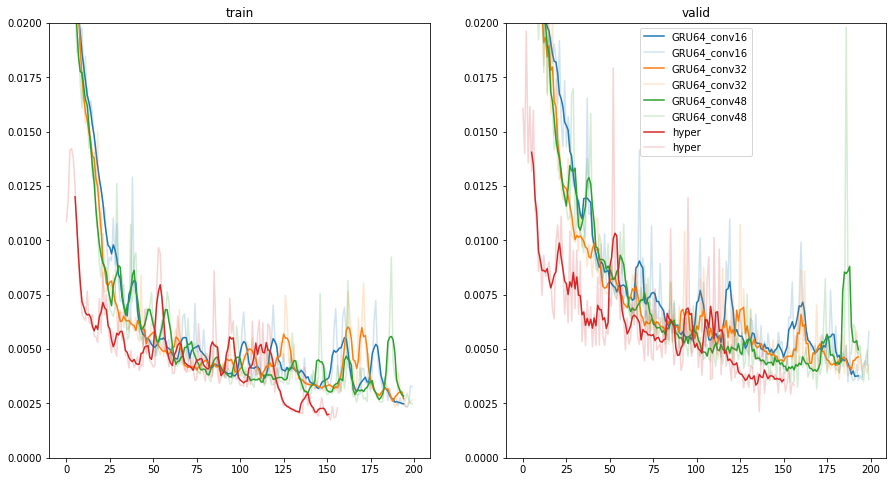

In [82]:
plot_results(result, ymax = 0.02, moving=5, alpha= 0.2, subset='hyper|conv', figsize=(15,8))

In [79]:
model.evaluate(valid_set)

2/2 [==============================] - 0s 25ms/step - loss: 0.0021 - mape: 7.0045


[0.002122680346171061, 7.00445644791672]

I got a mape below 10%! 
That's really a nice improvement and we have reached to requirements of the client. 

Note, how there is still a lot more to explore. For example, we saw that dropping the learning rate might be smart, and we did not play with that.
Also, SGD with momentum might still be giving better results. Those are open questions to explore, but for now we can be satisfied with finding a performance below target.

Let's see how that looks with a horizon of 8 in the actual prediction:

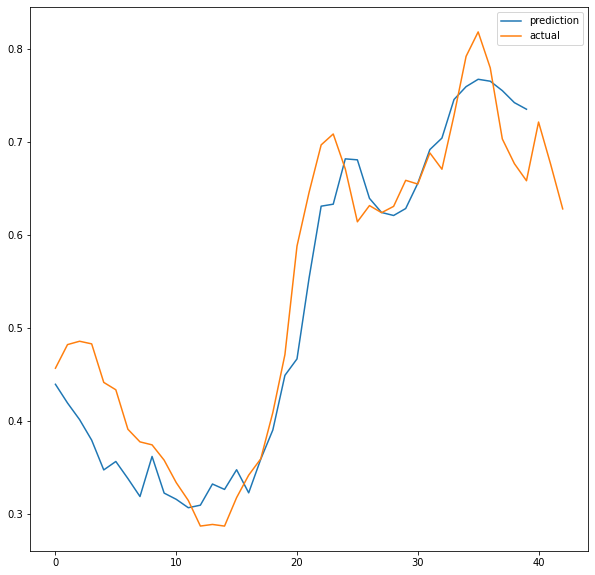

In [66]:
h = 8
#generate_prediction(model, pd.concat([x_train, x_valid]), window = seq_size, horizon = horizon);
generate_prediction(model, x_valid, window = seq_size, horizon = h);

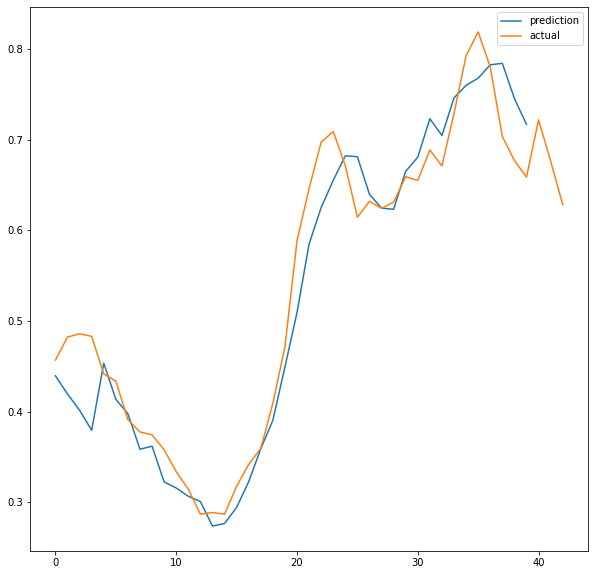

In [67]:
h = 4
generate_prediction(model, x_valid, window = seq_size, horizon = h);

# Saving and loading a model
save parameters

In [68]:
import json

json = json.dumps(best_hps.values)
f = open("bestvalues2.json","w")
f.write(json)
f.close()

In [69]:
model.save('best_model/')

INFO:tensorflow:Assets written to: best_model/assets
INFO:tensorflow:Assets written to: best_model/assets


In [70]:
model.evaluate(valid_set)

2/2 [==============================] - 0s 12ms/step - loss: 0.0021 - mape: 7.0045


[0.0021226804237812757, 7.00445644791672]

Load the saved model

In [71]:
from tensorflow.keras.models import load_model
model = load_model('best_model/')

# Check its architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 52)          208       
_________________________________________________________________
gru (GRU)                    (None, 32)                8256      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
Total params: 8,728
Trainable params: 8,728
Non-trainable params: 0
_________________________________________________________________


Test that it actually performs the same

In [76]:
model.evaluate(valid_set) 

2/2 [==============================] - 0s 9ms/step - loss: 0.0021 - mape: 7.0045


[0.0021226805401965976, 7.00445644791672]

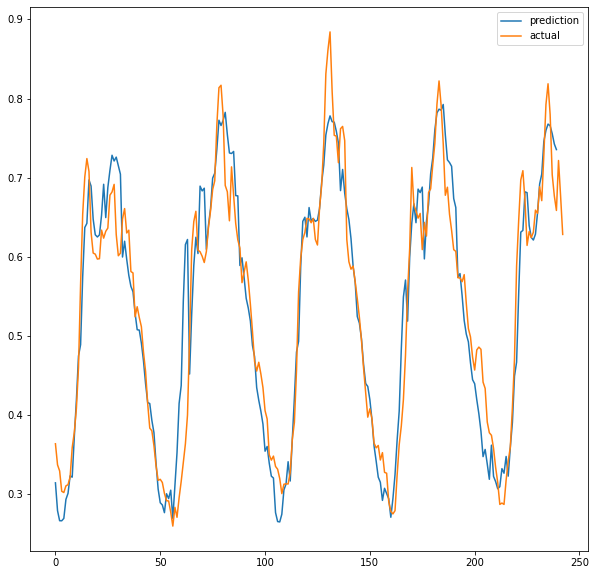

In [77]:
hr = 8
generate_prediction(model, pd.concat([x_train, x_valid]), window = seq_size, horizon = hr);

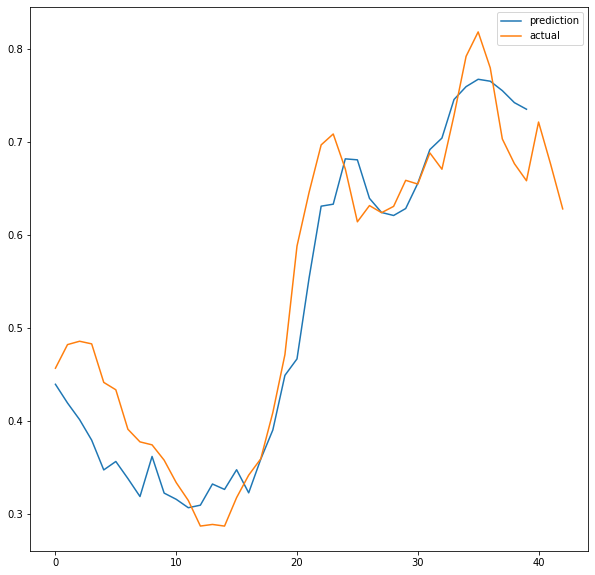

In [78]:
generate_prediction(model, x_valid, window = seq_size, horizon = hr);

In [ ]:
tock = datetime.datetime.now()
tock - tick